## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [116]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from src.features import add_trend
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Leitura dos Dados**

In [117]:
# leitura dos dados
train_df = pd.read_csv("data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [118]:
import json

with open("data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Random Forest Regression**

In [119]:
best_models = {}

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

In [120]:
def grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=3)
    search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    search.fit(X, y)
    return search.best_params_


def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = grid_search(
        estimator=RandomForestRegressor(ccp_alpha=0.0075, random_state=1001),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = RandomForestRegressor(**best_model)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [121]:
# aplicando modelo para cada série
rf_fcst = train_df.groupby("unique_id")\
    .progress_apply(random_forest)\
    .reset_index(drop=True)

100%|██████████| 15/15 [19:24<00:00, 77.63s/it]


In [122]:
with open("data/random_forest_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

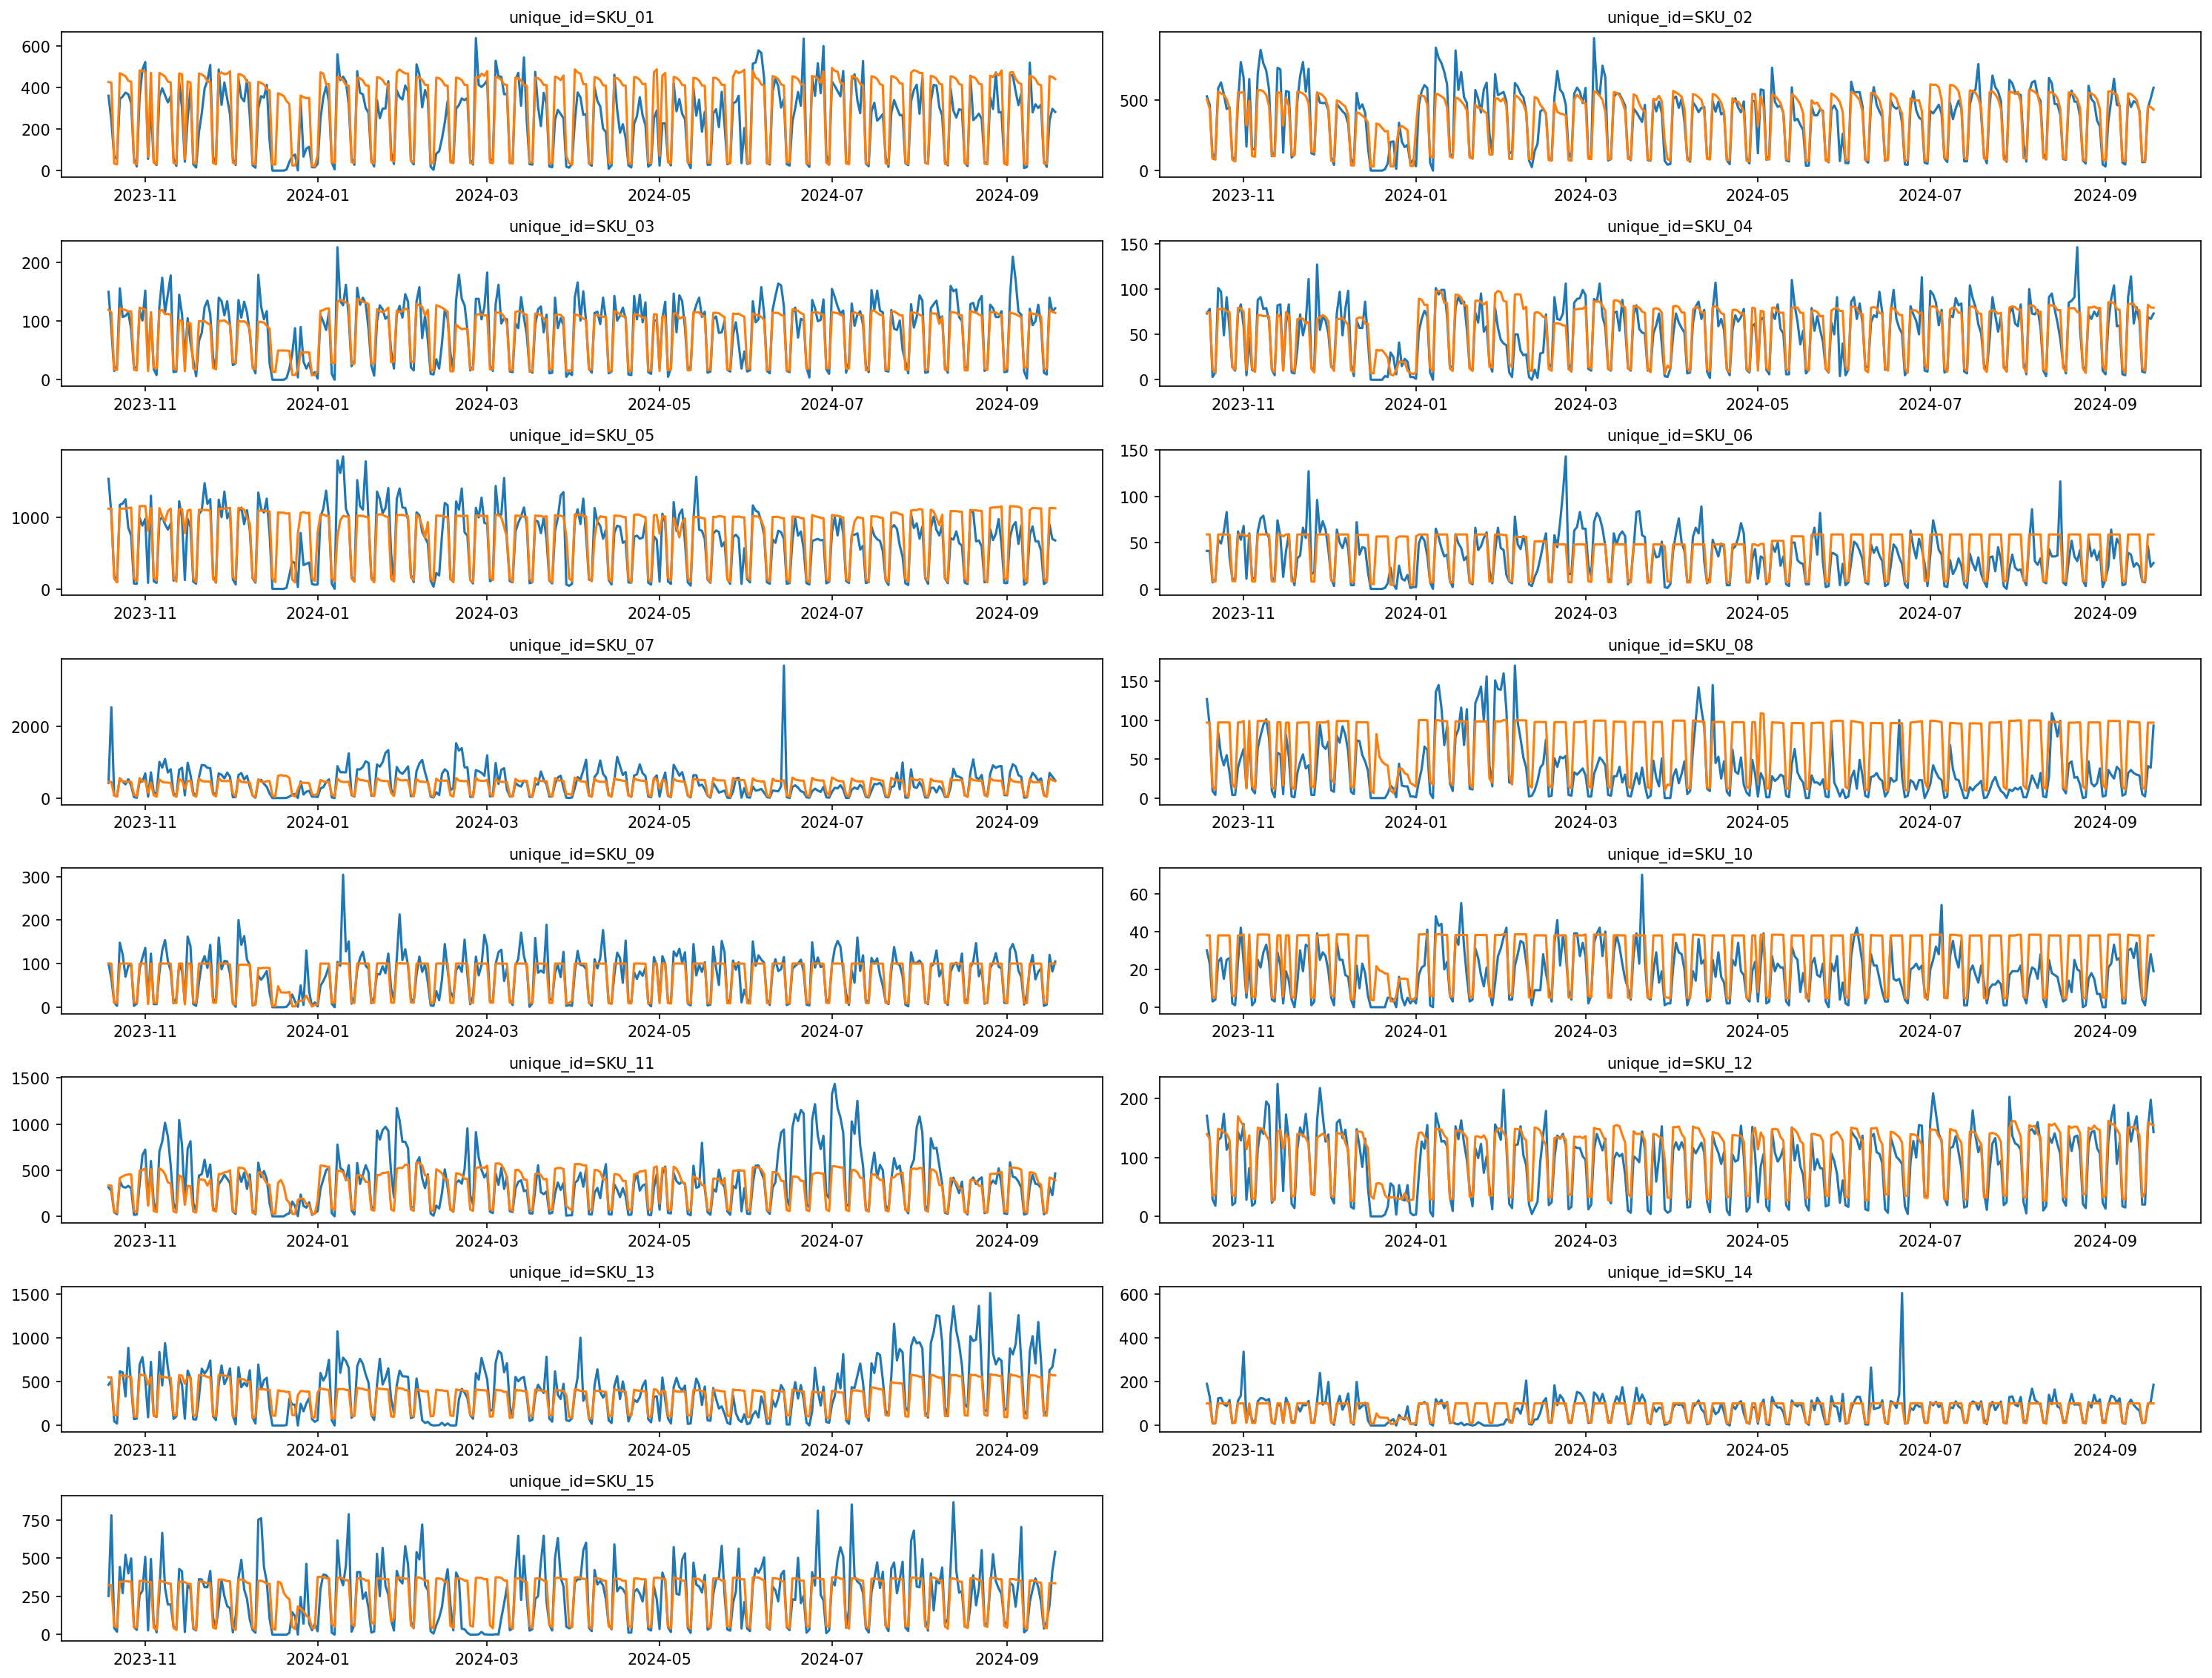

In [123]:
fig = plot_time_series(
    df=rf_fcst, 
    figsize=(20, 16),
    data_cols=['y', 'y_pred'], 
)

In [124]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,89.26,15075.59,122.78,0.46
SKU_02,74.14,11544.56,107.45,0.77
SKU_03,18.41,692.74,26.32,0.76
SKU_04,13.03,345.50,18.59,0.69
SKU_05,206.61,90007.50,300.01,0.55
SKU_06,15.53,455.83,21.35,0.27
SKU_07,206.79,112645.82,335.63,0.31
SKU_08,40.64,2478.45,49.78,-0.92
SKU_09,18.81,825.03,28.72,0.69
SKU_10,11.18,198.33,14.08,-0.23


In [125]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics[metrics['Random Forest'] > metrics['XGBoost']]

KeyError: 'XGBoost'